In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import os
import json
from pathlib import Path
import librosa
import scipy.signal
from tqdm.notebook import tqdm

In [98]:
FEATURES_DIR = Path("../features")

with open(FEATURES_DIR / "labels.json", "r") as f:
    LABEL_MAP = json.load(f)
LABEL_MAP = {k: int(v) for k, v in LABEL_MAP.items()}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

In [124]:
class AudioAugmentation:
    @staticmethod
    def time_stretch(spectrogram, rate_range=(0.8, 1.2)):
        rate = np.random.uniform(rate_range[0], rate_range[1])
        stretched = tf.image.resize(spectrogram, 
                                  [spectrogram.shape[0], 
                                   int(spectrogram.shape[1] * rate)])
        if stretched.shape[1] > spectrogram.shape[1]:
            stretched = stretched[:, :spectrogram.shape[1], :]
        elif stretched.shape[1] < spectrogram.shape[1]:
            pad_width = spectrogram.shape[1] - stretched.shape[1]
            stretched = tf.pad(stretched, [[0, 0], [0, pad_width], [0, 0]])
        return stretched

    @staticmethod
    def frequency_mask(spectrogram, freq_mask_param=15):
        freq_mask = np.random.randint(0, freq_mask_param)
        f0 = np.random.randint(0, spectrogram.shape[0] - freq_mask)
        masked = spectrogram.numpy().copy()
        masked[f0:f0+freq_mask, :, :] = 0
        return tf.constant(masked)

    @staticmethod
    def time_mask(spectrogram, time_mask_param=35):
        time_mask = np.random.randint(0, time_mask_param)
        t0 = np.random.randint(0, spectrogram.shape[1] - time_mask)
        masked = spectrogram.numpy().copy()
        masked[:, t0:t0+time_mask, :] = 0
        return tf.constant(masked)

    @staticmethod
    def add_noise(spectrogram, noise_factor=0.01):
        noise = tf.random.normal(tf.shape(spectrogram), 0, noise_factor)
        return spectrogram + noise

    @staticmethod
    def mixup(spec1, spec2, label1, label2, alpha=0.2):
        lam = np.random.beta(alpha, alpha)
        mixed_spec = lam * spec1 + (1 - lam) * spec2
        return mixed_spec, lam * label1 + (1 - lam) * label2

def augment_spectrogram(spectrogram, augment_prob=0.5):
    if np.random.random() < augment_prob:
        aug_choice = np.random.choice(['time_stretch', 'freq_mask', 'time_mask', 'noise'])
        
        if aug_choice == 'time_stretch':
            return AudioAugmentation.time_stretch(spectrogram)
        elif aug_choice == 'freq_mask':
            return AudioAugmentation.frequency_mask(spectrogram)
        elif aug_choice == 'time_mask':
            return AudioAugmentation.time_mask(spectrogram)
        elif aug_choice == 'noise':
            return AudioAugmentation.add_noise(spectrogram)
    
    return spectrogram

def load_feature_dir(dir_path: Path, target_shape=(64, 128, 1), apply_augmentation=False):
    """
    Load .npy files and resize/pad to match target shape with progress bar
    """
    features = []
    labels = []

    npy_files = list(dir_path.glob("*.npy"))
    print(f"🔍 Found {len(npy_files)} .npy files in {dir_path}")

    # Add progress bar for file loading
    for npy_file in tqdm(npy_files, desc=f"Loading {dir_path.name} data", unit="files"):
        try:
            data = np.load(npy_file, allow_pickle=True).item()
            x = data['features']
            label = data['label']

            if x.ndim == 2:
                x = x[..., np.newaxis]

            # 🧩 Resize or crop to match target shape
            h, w, c = x.shape
            th, tw, tc = target_shape

            # Crop or pad height
            if h < th:
                pad_h = th - h
                x = np.pad(x, ((0, pad_h), (0, 0), (0, 0)), mode='constant')
            elif h > th:
                x = x[:th, :, :]

            # Crop or pad width
            if w < tw:
                pad_w = tw - w
                x = np.pad(x, ((0, 0), (0, pad_w), (0, 0)), mode='constant')
            elif w > tw:
                x = x[:, :tw, :]

            # Apply augmentation if enabled
            if apply_augmentation:
                x = augment_spectrogram(tf.constant(x, dtype=tf.float32)).numpy()

            features.append(x)
            labels.append(label)

        except Exception as e:
            print(f"❌ Failed to load {npy_file.name}: {e}")

    X = np.stack(features)
    return X, labels

In [125]:
X_train, y_train_str = load_feature_dir(Path(f"{FEATURES_DIR}/train"), target_shape=(64, 421, 1), apply_augmentation=True)
print(f"✅ X_train type: {type(X_train)}, shape: {X_train.shape}")
print(f"✅ y_train type: {type(y_train_str)}, example: {y_train_str[:5]}")
print("🎵 Applied audio augmentation to training data")

🔍 Found 1536 .npy files in ../features/train


Loading train data:   0%|          | 0/1536 [00:00<?, ?files/s]

✅ X_train type: <class 'numpy.ndarray'>, shape: (1536, 64, 421, 1)
✅ y_train type: <class 'list'>, example: [30, 19, 33, 30, 13]
🎵 Applied audio augmentation to training data


In [126]:
class_counts_df = pd.Series(y_train_str).value_counts().reset_index()
class_counts_df.columns = ['Class', 'Count']
class_counts_df = class_counts_df.sort_values(by="Count", ascending=False)


# 📊 วาด histogram ด้วย Plotly
fig = px.bar(
    class_counts_df,
    x='Class',
    y='Count',
    title="Class Distribution in Training Set",
    labels={'Count': 'Number of Samples'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_tickangle=-45,
    bargap=0.2
)

fig.show()

In [127]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train_str)
input_shape = X_train.shape[1:] 

In [128]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=1.0, gamma=2.0, from_logits=False, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)
        
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        ce_loss = -y_true_one_hot * tf.math.log(y_pred)
        pt = tf.where(tf.equal(y_true_one_hot, 1), y_pred, 1 - y_pred)
        focal_weight = self.alpha * tf.pow(1 - pt, self.gamma)
        
        focal_loss = focal_weight * ce_loss
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    def get_config(self):
        config = super(FocalLoss, self).get_config()
        config.update({
            'alpha': self.alpha,
            'gamma': self.gamma,
            'from_logits': self.from_logits
        })
        return config

class_weight_dict = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: w for i, w in enumerate(class_weight_dict)}
print("📊 Class weights:", class_weights)

focal_loss = FocalLoss(alpha=1.0, gamma=2.0)
print("✅ Focal Loss initialized")

📊 Class weights: {0: 0.12914074323188163, 1: 2.0210526315789474, 2: 2.3777089783281733, 3: 3.3684210526315788, 4: 3.1093117408906883, 5: 3.1093117408906883, 6: 2.1274238227146816, 7: 2.526315789473684, 8: 2.526315789473684, 9: 2.245614035087719, 10: 2.694736842105263, 11: 0.14915517576228393, 12: 2.1274238227146816, 13: 0.14232765011119347, 14: 2.694736842105263, 15: 2.526315789473684, 16: 0.7349282296650718, 17: 2.3777089783281733, 18: 2.3777089783281733, 19: 2.0210526315789474, 20: 2.3777089783281733, 21: 2.1274238227146816, 22: 2.245614035087719, 23: 1.8373205741626795, 24: 2.1274238227146816, 25: 2.526315789473684, 26: 2.3777089783281733, 27: 2.694736842105263, 28: 2.245614035087719, 29: 2.0210526315789474, 30: 0.9624060150375939, 31: 1.9248120300751879, 32: 2.1274238227146816, 33: 2.3777089783281733, 34: 2.694736842105263, 35: 2.887218045112782, 36: 1.757437070938215, 37: 2.245614035087719}
✅ Focal Loss initialized


In [129]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),  # Replace Flatten to reduce parameters
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(encoder.classes_), activation='softmax')
])

print("✅ Model with regularization created")
print(f"🎯 Target classes: {len(encoder.classes_)}")
model.summary()

✅ Model with regularization created
🎯 Target classes: 38


/Users/ittichaiboonyarakthunya/Documents/WorkDir/ai-ml/labs-gunshot-classification/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 62, 419, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 419, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 209, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 31, 209, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 29, 207, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 29, 207, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 103, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 103, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 101, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 101, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,494 (451.15 KB)

 Trainable params: 114,790 (448.40 KB)

 Non-trainable params: 704 (2.75 KB)

In [130]:
class TqdmCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_progress = None
        
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.epoch_progress = tqdm(total=self.epochs, desc="Training Progress", unit="epoch")
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_progress.update(1)
        # Update progress bar description with current metrics
        desc = f"Epoch {epoch+1}/{self.epochs} - loss: {logs.get('loss', 0):.4f} - acc: {logs.get('accuracy', 0):.4f} - val_loss: {logs.get('val_loss', 0):.4f} - val_acc: {logs.get('val_accuracy', 0):.4f}"
        self.epoch_progress.set_description(desc)
        
    def on_train_end(self, logs=None):
        if self.epoch_progress:
            self.epoch_progress.close()

# Reduce learning rate and add L2 regularization
optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=focal_loss,
    metrics=['accuracy']
)

# More aggressive early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# Add learning rate reduction
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

tqdm_callback = TqdmCallback()

print("✅ Model compiled with anti-overfitting strategies:")

✅ Model compiled with anti-overfitting strategies:


In [131]:
X_val,   y_val_str   = load_feature_dir(Path(f"{FEATURES_DIR}/val"),   target_shape=(64, 421, 1))
encoder = LabelEncoder()
encoder.fit(y_train_str + y_val_str)  # รวมเพื่อให้คลาสตรงกัน
y_train = encoder.transform(y_train_str)
y_val = encoder.transform(y_val_str)

🔍 Found 329 .npy files in ../features/val


Loading val data:   0%|          | 0/329 [00:00<?, ?files/s]

In [132]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # More epochs but with early stopping
    batch_size=32,
    verbose=0,
    callbacks=[
        ModelCheckpoint(
            Path("models/v4_regularized_model.keras"), 
            save_best_only=True,
            monitor='val_loss',
            verbose=1
        ),
        early_stop,
        lr_reduce,
        tqdm_callback
    ]
)

print("✅ Training completed with regularization techniques")

Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]


Epoch 1: val_loss improved from inf to 3.41372, saving model to models/v4_regularized_model.keras

Epoch 2: val_loss improved from 3.41372 to 3.41060, saving model to models/v4_regularized_model.keras

Epoch 3: val_loss did not improve from 3.41060

Epoch 4: val_loss improved from 3.41060 to 3.35556, saving model to models/v4_regularized_model.keras

Epoch 5: val_loss improved from 3.35556 to 3.35268, saving model to models/v4_regularized_model.keras

Epoch 6: val_loss did not improve from 3.35268

Epoch 7: val_loss improved from 3.35268 to 3.35181, saving model to models/v4_regularized_model.keras

Epoch 8: val_loss did not improve from 3.35181

Epoch 9: val_loss did not improve from 3.35181

Epoch 10: val_loss did not improve from 3.35181

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 11: val_loss did not improve from 3.35181

Epoch 12: val_loss did not improve from 3.35181

Epoch 13: val_loss did not improve from 3.35181

Epoch 13: ReduceLROnPl

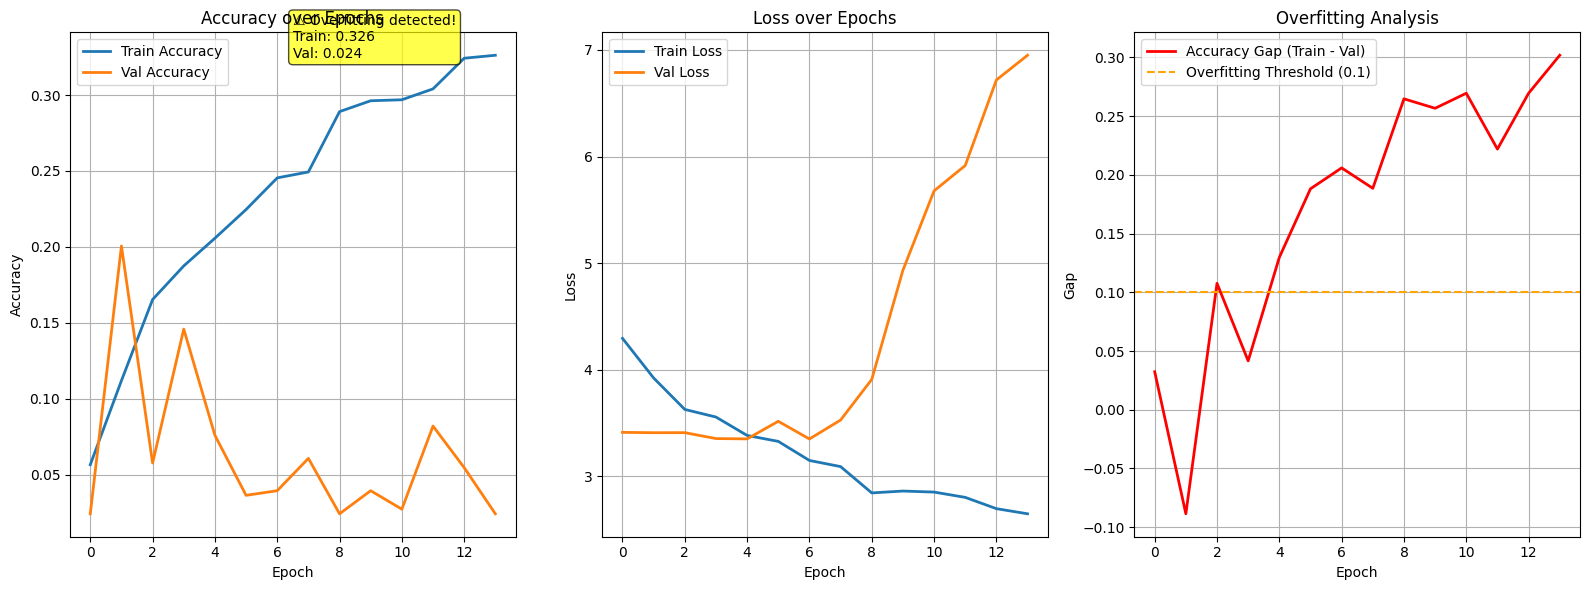

📊 Training Summary:
Final Train Accuracy: 0.3262
Final Val Accuracy: 0.0243
Accuracy Gap: 0.3019
🚨 Severe overfitting detected!


In [133]:
def plot_training_history(history):
    plt.figure(figsize=(16, 6))

    # 🎯 Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    
    # Check for overfitting
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    if train_acc - val_acc > 0.1:
        plt.text(0.5, 0.95, f'⚠️ Overfitting detected!\nTrain: {train_acc:.3f}\nVal: {val_acc:.3f}', 
                transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='yellow', alpha=0.7))

    # 📉 Loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    
    # Gap analysis
    plt.subplot(1, 3, 3)
    acc_gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    plt.plot(acc_gap, label='Accuracy Gap (Train - Val)', color='red', linewidth=2)
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Overfitting Threshold (0.1)')
    plt.xlabel('Epoch')
    plt.ylabel('Gap')
    plt.title('Overfitting Analysis')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # Print summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    
    print(f"📊 Training Summary:")
    print(f"Final Train Accuracy: {final_train_acc:.4f}")
    print(f"Final Val Accuracy: {final_val_acc:.4f}")
    print(f"Accuracy Gap: {gap:.4f}")
    
    if gap > 0.15:
        print("🚨 Severe overfitting detected!")
    elif gap > 0.1:
        print("⚠️ Moderate overfitting detected")
    else:
        print("✅ Good generalization")

plot_training_history(history)

In [110]:
X_test,   y_test_str   = load_feature_dir(Path(f"{FEATURES_DIR}/test"),   target_shape=(64, 421, 1))

inverse_label_map = {v: k for k, v in LABEL_MAP.items()}
y_test_names = [inverse_label_map[y] if isinstance(y, int) else y for y in y_test_str]


# 🔁 Encode labels
encoder = LabelEncoder()
encoder.fit(list(LABEL_MAP.keys()))  # ใช้ label map เดิม
y_test = encoder.transform(y_test_names)

🔍 Found 330 .npy files in ../features/test


Loading test data:   0%|          | 0/330 [00:00<?, ?files/s]

🔍 Making predictions on test set...
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
📊 Computing confusion matrix...


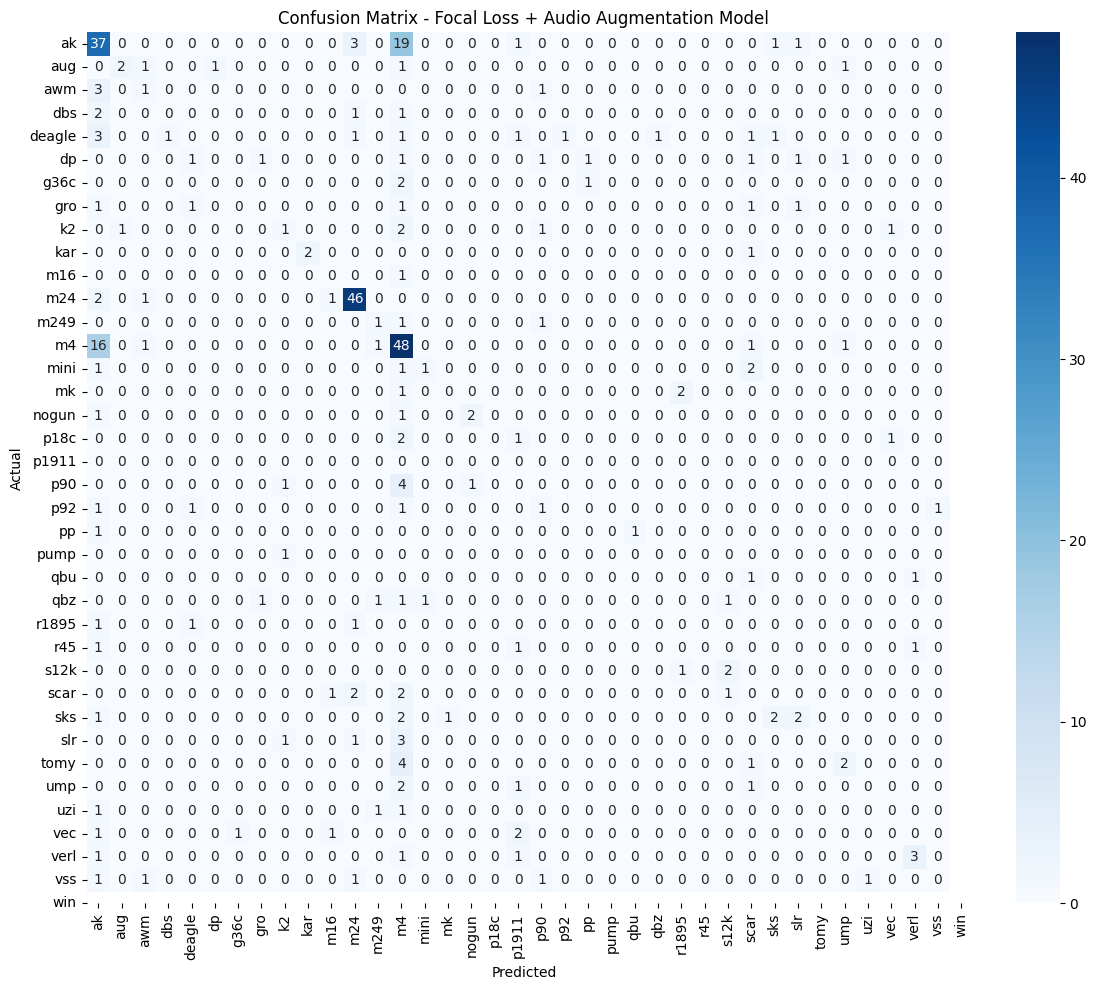

🎯 Classification Report - Focal Loss + Audio Augmentation:
              precision    recall  f1-score   support

          ak       0.49      0.60      0.54        62
         aug       0.67      0.33      0.44         6
         awm       0.20      0.20      0.20         5
         dbs       0.00      0.00      0.00         4
      deagle       0.00      0.00      0.00        11
          dp       0.00      0.00      0.00         8
        g36c       0.00      0.00      0.00         3
         gro       0.00      0.00      0.00         5
          k2       0.25      0.17      0.20         6
         kar       1.00      0.67      0.80         3
         m16       0.00      0.00      0.00         1
         m24       0.82      0.92      0.87        50
        m249       0.25      0.33      0.29         3
          m4       0.46      0.71      0.56        68
        mini       0.50      0.20      0.29         5
          mk       0.00      0.00      0.00         3
       nogun       0.6

/Users/ittichaiboonyarakthunya/Documents/WorkDir/ai-ml/labs-gunshot-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/ittichaiboonyarakthunya/Documents/WorkDir/ai-ml/labs-gunshot-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/ittichaiboonyarakthunya/Documents/WorkDir/ai-ml/labs-gunshot-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/ittichaiboonyarakthunya/Docum

In [114]:
# Model Evaluation with Focal Loss and Augmentation
print("🔍 Making predictions on test set...")
y_pred_probs = model.predict(X_test, verbose=1)  # Show progress for predictions
y_preds = np.argmax(y_pred_probs, axis=1)

print("📊 Computing confusion matrix...")
cm = confusion_matrix(y_test, y_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Focal Loss + Audio Augmentation Model")
plt.tight_layout()
plt.show()

# Print detailed classification report - fix the class mismatch
print("🎯 Classification Report - Focal Loss + Audio Augmentation:")
unique_classes = np.unique(np.concatenate([y_test, y_preds]))
target_names = [encoder.classes_[i] for i in unique_classes]
print(classification_report(y_test, y_preds, labels=unique_classes, target_names=target_names))


In [116]:
print("📈 Computing detailed metrics...")
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_preds, average=None, labels=unique_classes)

# Create a DataFrame for easier analysis
results_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n📊 Per-Class Performance Metrics:")
print(results_df.sort_values('Support'))

# Focus on minority classes (support < 10)
minority_classes = results_df[results_df['Support'] < 10]
if not minority_classes.empty:
    print(f"\n🎯 Minority Classes Performance (support < 10):")
    print(f"Average F1-Score for minority classes: {minority_classes['F1-Score'].mean():.3f}")
    print(f"Average Recall for minority classes: {minority_classes['Recall'].mean():.3f}")
    print(f"Average Precision for minority classes: {minority_classes['Precision'].mean():.3f}")

print(f"\n📈 Overall Performance:")
print(f"Macro Average F1-Score: {f1.mean():.3f}")
print(f"Weighted Average F1-Score: {np.average(f1, weights=support):.3f}")

# Debug information
print(f"\n🔧 Debug Info:")
print(f"Total encoder classes: {len(encoder.classes_)}")
print(f"Unique classes in test+pred: {len(unique_classes)}")
print(f"Missing classes: {set(range(len(encoder.classes_))) - set(unique_classes)}")

📈 Computing detailed metrics...

📊 Per-Class Performance Metrics:
     Class  Precision    Recall  F1-Score  Support
18   p1911   0.000000  0.000000  0.000000        0
10     m16   0.000000  0.000000  0.000000        1
22    pump   0.000000  0.000000  0.000000        1
23     qbu   0.000000  0.000000  0.000000        2
21      pp   0.000000  0.000000  0.000000        2
6     g36c   0.000000  0.000000  0.000000        3
27    s12k   0.500000  0.666667  0.571429        3
26     r45   0.000000  0.000000  0.000000        3
33     vec   0.000000  0.000000  0.000000        3
25   r1895   0.000000  0.000000  0.000000        3
12    m249   0.250000  0.333333  0.285714        3
15      mk   0.000000  0.000000  0.000000        3
9      kar   1.000000  0.666667  0.800000        3
3      dbs   0.000000  0.000000  0.000000        4
16   nogun   0.666667  0.500000  0.571429        4
17    p18c   0.000000  0.000000  0.000000        4
32     uzi   0.000000  0.000000  0.000000        4
30     slr   0.0

/Users/ittichaiboonyarakthunya/Documents/WorkDir/ai-ml/labs-gunshot-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/ittichaiboonyarakthunya/Documents/WorkDir/ai-ml/labs-gunshot-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

